# Multivariate risk management. Part 2

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms
    
    
- Advanced models
    - Gaussian Mixture
    - Copulas
        - Explanation
        - Using GARCH as a univariate ditribution
        
        
- Backtesting
    - Kupiec test
    
    
    
## References
- [Multivariate Models](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_06.pdf)
- [Copulas](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_07.pdf)
- [Multivariate Volatility Models](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-3.pdf)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'
# %config InlineBackend.figure_formats=["png"]

## Data

### Upload and visualize data

Get the data for the Dow Jones Industrial Average stocks by specifying the stock tickers, start date, and end date

https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI

In [2]:
# Students are advised to use other data sources. This is just for the sake of brevity.
# !pip install yfinance

In [2]:
import yfinance as yf

# selected_companies = ['AAPL',  'MSFT', 'MMM']
selected_companies = ['AAPL',  'MSFT', 'MMM', 'NKE', 'GS']

dwj_companies = 'VZ UNH JNJ PG MRK RTX KO WBA MMM WMT MSFT IBM INTC AAPL CSCO '
dwj_companies += 'NKE CAT PFE XOM MCD JPM HD V GS DIS AXP CVX TRV BA' # DOW

data = yf.download(dwj_companies, '2016-01-01','2019-12-31' , group_by="column")

data.head()

[*********************100%***********************]  29 of 29 downloaded


Adj Close                                                     \
                AAPL    AXP      BA    CAT   CSCO    CVX    DIS      GS   
Date                                                                      
2015-12-31     97.86  64.35  128.68  58.10  23.34  74.66  99.14  167.31   
2016-01-04     97.95  62.53  125.04  58.12  22.87  73.74  97.16  164.45   
2016-01-05     95.49  61.57  125.55  57.52  22.77  74.37  95.19  161.61   
2016-01-06     93.63  59.86  123.55  56.61  22.52  71.43  94.68  157.67   
2016-01-07     89.67  59.32  118.37  54.66  22.00  68.90  93.87  152.82   

                            ...      Volume                          \
                HD     IBM  ...         PFE          PG         RTX   
Date                        ...                                       
2015-12-31  118.99  112.70  ...  21103900.0   5077700.0   4689100.0   
2016-01-04  117.93  111.33  ...  37307800.0  11529800.0   8552300.0   
2016-01-05  117.35  111.25  ...  27303600.0   8133700.0   6758100.0   
2016-01-06  116.14  110.69  ...  25846600.0   9551000.0  13189600.0   
2016-01-07  112.82  108.80  ...  37213600.0  11973900.0  11098800.0   

                                                                      \
                  TRV        UNH           V          VZ         WBA   
Date                                                                   
2015-12-31   956100.0  2372500.0   6538300.0  11490900.0   2528700.0   
2016-01-04  2846000.0  4991000.0  13476800.0  17821600.0   6347600.0   
2016-01-05  1870400.0  2816800.0   8972700.0  15632800.0   7603100.0   
2016-01-06  1730900.0  2677300.0  16092000.0  19082700.0  11659200.0   
2016-01-07  2284400.0  5277200.0  12470800.0  19277600.0  11362000.0   

                                    
                   WMT         XOM  
Date                                
2015-12-31   6575100.0  10285500.0  
2016-01-04  11989200.0  20400100.0  
2016-01-05  13326000.0  11993500.0  
2016-01-06  16564600.0  18826900.0  
2016-01-07  26430000.0  21263800.0  

[5 rows x 174 columns]

In [3]:
prices = data['Adj Close'].dropna()

print(prices.shape)
prices.head()

(1006, 29)


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,97.86,64.35,128.68,58.10,23.34,74.66,99.14,167.31,118.99,112.70,...,27.04,68.74,54.12,101.62,109.57,75.04,37.41,76.08,54.82,64.27
2016-01-04,97.95,62.53,125.04,58.12,22.87,73.74,97.16,164.45,117.93,111.33,...,26.77,67.84,53.84,99.02,108.47,73.25,37.12,74.19,54.97,63.87
2016-01-05,95.49,61.57,125.55,57.52,22.77,74.37,95.19,161.61,117.35,111.25,...,26.96,68.05,53.93,99.47,108.68,73.81,37.63,72.24,56.27,64.41
2016-01-06,93.63,59.86,123.55,56.61,22.52,71.43,94.68,157.67,116.14,110.69,...,26.48,67.40,52.46,98.18,107.57,72.84,37.29,71.14,56.83,63.88
2016-01-07,89.67,59.32,118.37,54.66,22.00,68.90,93.87,152.82,112.82,108.80,...,26.30,66.81,51.77,95.84,104.40,71.41,37.09,72.51,58.16,62.86


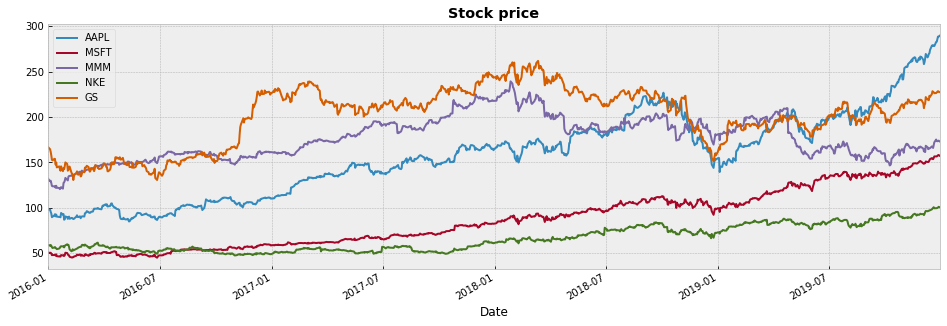

In [4]:
prices.loc[:,selected_companies].plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

We convert datetime index to period

In [5]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)
PeriodIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
             '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
             '2016-01-13', '2016-01-14',
             ...
             '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
             '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
             '2019-12-27', '2019-12-30'],
            dtype='period[D]', name='Date', length=1006, freq='D')


In [6]:
returns = prices.pct_change().dropna()

returns.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.000920,-0.028283,-0.028287,0.000344,-0.020137,-0.012323,-0.019972,-0.017094,-0.008908,-0.012156,...,-0.009985,-0.013093,-0.005174,-0.025586,-0.010039,-0.023854,-0.007752,-0.024842,0.002736,-0.006224
2016-01-05,-0.025115,-0.015353,0.004079,-0.010323,-0.004373,0.008544,-0.020276,-0.017270,-0.004918,-0.000719,...,0.007097,0.003096,0.001672,0.004545,0.001936,0.007645,0.013739,-0.026284,0.023649,0.008455
2016-01-06,-0.019478,-0.027773,-0.015930,-0.015821,-0.010979,-0.039532,-0.005358,-0.024380,-0.010311,-0.005034,...,-0.017804,-0.009552,-0.027258,-0.012969,-0.010213,-0.013142,-0.009035,-0.015227,0.009952,-0.008229
2016-01-07,-0.042294,-0.009021,-0.041926,-0.034446,-0.023091,-0.035419,-0.008555,-0.030760,-0.028586,-0.017075,...,-0.006798,-0.008754,-0.013153,-0.023834,-0.029469,-0.019632,-0.005363,0.019258,0.023403,-0.015967
2016-01-08,0.005353,-0.003203,-0.022641,-0.010062,-0.024545,-0.010740,-0.002450,-0.004122,-0.011966,-0.009283,...,-0.012548,-0.015716,-0.016226,-0.004174,-0.017146,-0.012323,-0.009706,-0.001379,-0.022868,-0.020204


### Plot histograms

Look at histograms and scatterplots for some stocks

<Figure size 504x504 with 0 Axes>

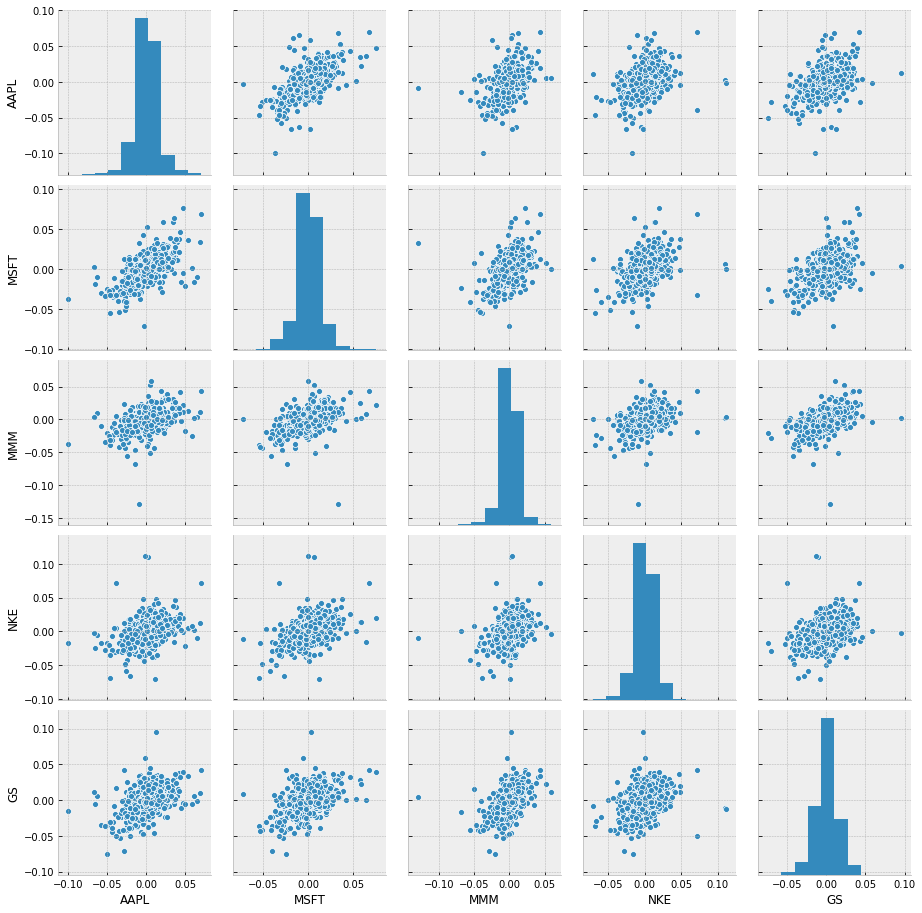

In [8]:
fig = plt.figure(figsize=(7, 7))

sns.pairplot(returns[selected_companies])

plt.show()

Let's consider a case of equally-weighted portfolio

In [7]:
# w = np.ones(shape=(returns.shape[1],)) / returns.shape[1]

w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

# w_temp = np.ones(shape=(len(selected_companies),)) / len(selected_companies)

w_temp = 1 / prices[selected_companies].iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns[selected_companies].values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)

print(w)
print(w_temp)

AAPL    0.021303
AXP     0.032396
BA      0.016200
CAT     0.035881
CSCO    0.089318
CVX     0.027922
DIS     0.021028
GS      0.012460
HD      0.017520
IBM     0.018498
INTC    0.068260
JNJ     0.022914
JPM     0.036217
KO      0.056266
MCD     0.019846
MMM     0.015726
MRK     0.045181
MSFT    0.040972
NKE     0.035238
PFE     0.077096
PG      0.030327
RTX     0.038519
TRV     0.020514
UNH     0.019026
V       0.027781
VZ      0.055725
WBA     0.027401
WMT     0.038028
XOM     0.032436
Name: 2015-12-31, dtype: float64
AAPL    0.169473
MSFT    0.325956
MMM     0.125110
NKE     0.280335
GS      0.099125
Name: 2015-12-31, dtype: float64


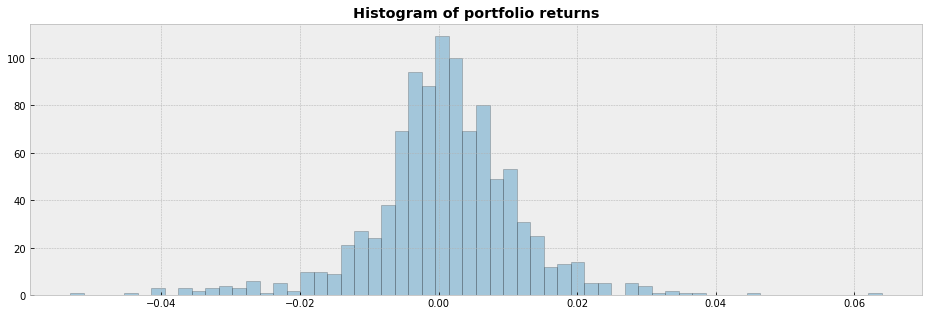

In [8]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of portfolio returns", weight="bold")

plt.show()

And for additional vizualization let's look at join distribution of only two stocks

In [9]:
ticker_one = 'AAPL'
ticker_two = 'MMM'

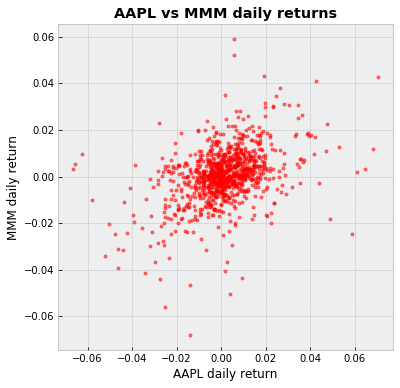

In [10]:
my_lim = 0.08

idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)

x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]

fig = plt.figure(figsize=(6, 6))

plt.plot(x, y, "r.", alpha=0.5)

plt.xlabel("{} daily return".format(ticker_one))
plt.ylabel("{} daily return".format(ticker_two))
plt.title("{} vs {} daily returns".format(ticker_one, ticker_two), weight="bold")

plt.show()

In [11]:
alpha = 0.05

## Advanced models

### Gaussian Mixture

In [14]:
from sklearn.mixture import GaussianMixture

n_samples = 10 ** 4

gmm = GaussianMixture(n_components=6, covariance_type='full', n_init=10, random_state=42) # full spherical
gmm.fit(returns[selected_companies].values)

return_simulations = gmm.sample(n_samples=n_samples)[0]

return_simulations = pd.DataFrame(return_simulations, columns=selected_companies)

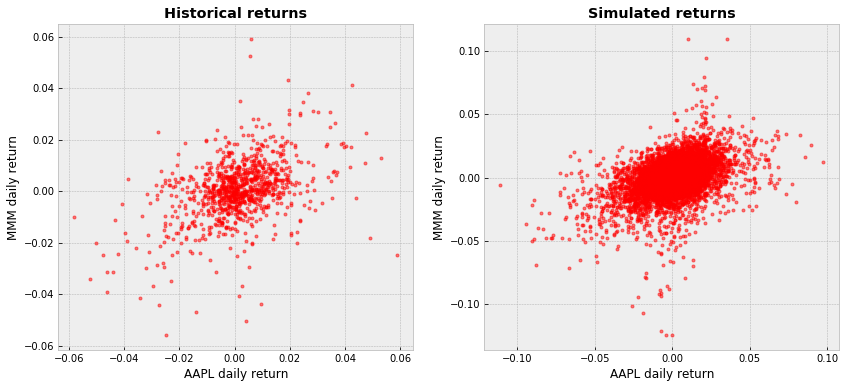

In [15]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.06
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


my_lim = 0.2
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} daily return".format(ticker_one))
plt2.set_ylabel("{} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

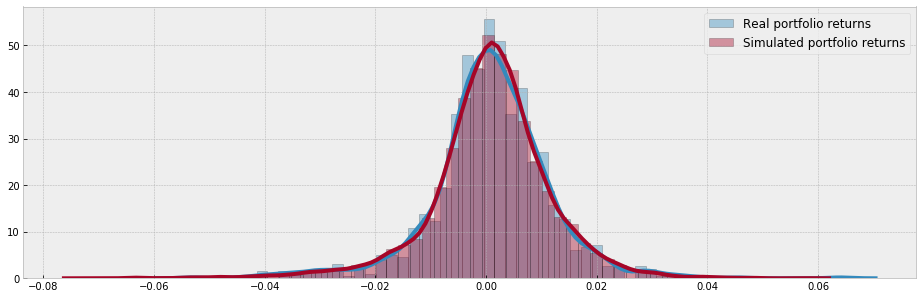

In [16]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [17]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.016684940782557837
-0.017289703435701013


#### Wrapping into functions

In [18]:
def make_gmm_simulations(returns, n_samples=10**3):

    n_components = 6

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=3, random_state=42) # full spherical
    gmm.fit(returns.values)

    return_simulations = gmm.sample(n_samples=n_samples)[0]

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations


def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__)

In [33]:
VaR_gmm_6 = calc_VaR(returns[selected_companies], make_gmm_simulations, w_temp)

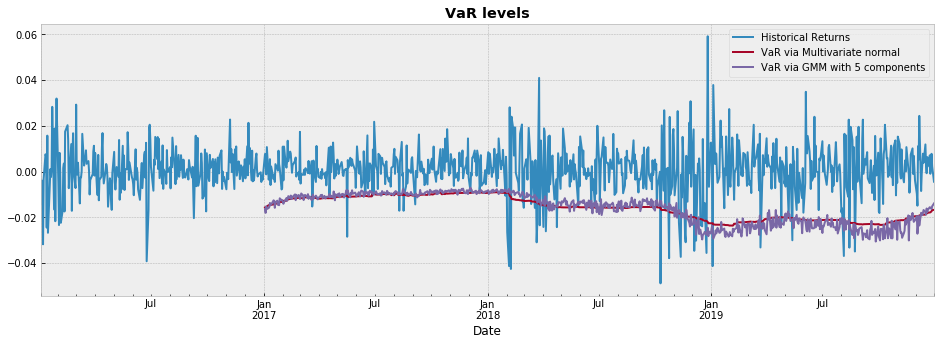

In [34]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
VaR_multy_normal.plot()
VaR_gmm_6.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Multivariate normal',
            'VaR via GMM with 5 components'])

plt.show()

### Copulas

Steps:
1. Model univariate distributions
2. ...

In [35]:
# https://copulae.readthedocs.io/en/latest/examples/usage_guide.html
# !pip install copulae

#### Step 1

In [19]:
import scipy.stats as ss

cdfs = returns[selected_companies].copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = ss.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = ss.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [20]:
distribution_params

{'AAPL': (2.9640174470814755, 0.001458238750311541, 0.009713565656445008),
 'MSFT': (3.064955929136702, 0.0014207699144579292, 0.008961022171113496),
 'MMM': (2.781966720215749, 0.0008862174524367015, 0.007403101407598036),
 'NKE': (3.9168800151867993, 0.0006960699297001857, 0.010444728954884179),
 'GS': (4.346481613829226, 0.0006255226774620083, 0.011418521461940282)}

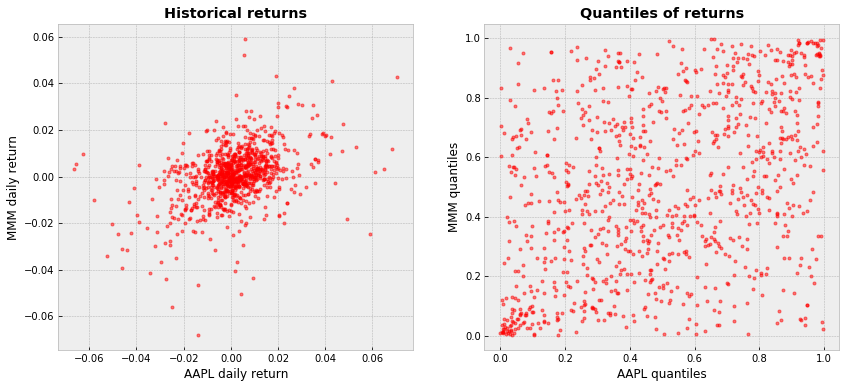

In [21]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} quantiles".format(ticker_one))
plt2.set_ylabel("{} quantiles".format(ticker_two))
plt2.set_title("Quantiles of returns", weight="bold")

plt.show()

In [39]:
# h = sns.jointplot(x, y, kind='kde', xlim=(0, 1), ylim=(0, 1), stat_func=None)
# h.set_axis_labels('Maximum river level', 'Probablity of flooding', fontsize=16)

#### Step 2

In [22]:
from copulae import NormalCopula

cop = NormalCopula(dim=cdfs.shape[1])
cop.fit(cdfs)

cop.summary()

Gaussian Copula Summary
================================================================================
Gaussian Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
 1.000000  0.591046  0.420420  0.360072  0.440145
 0.591046  1.000000  0.489952  0.445360  0.459743
 0.420420  0.489952  1.000000  0.386692  0.524385
 0.360072  0.445360  0.386692  1.000000  0.352861
 0.440145  0.459743  0.524385  0.352861  1.000000



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -720.2676713354358
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1005

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [0.59104601 0.42042049 0.36007164 0.44014475 0.4899524  0.4453604
 0.45974293 0.38669169 0.5243852  0.35286054]
	fun            : -720.2676713354358
	jac            : [-1.54614099e-03 -1.06107715e-04  6.74541904e-04 -3.71377003e-04
  1.02318154e-03 -7.27595761e-04 -1.10655189e-03 -2.88006656e-04
 -1.49308714e-03  3.03164901e-05]
	nit            : 15
	nfev           : 210
	njev           : 15
	status         : 0
	message        : Optimization terminated successfully.
	success        : True

#### Step 3

In [23]:
n_samples = 10 ** 4

copula_simulations = cop.random(n_samples, seed=42)

copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

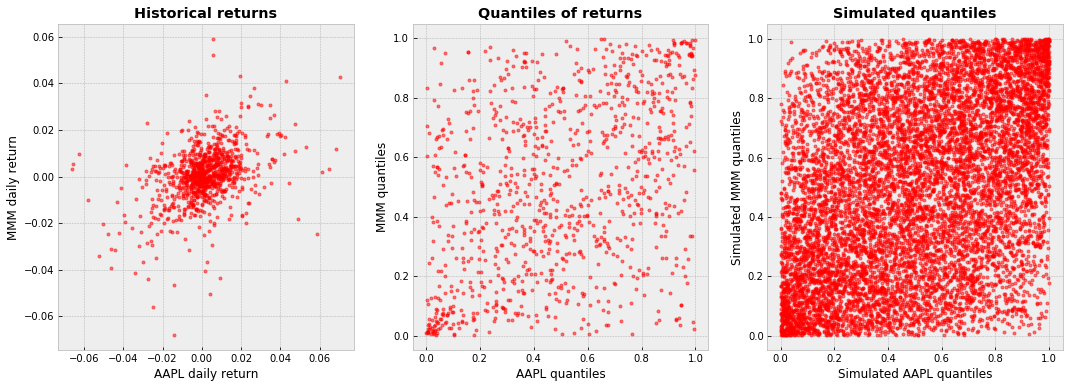

In [24]:
fig = plt.figure(figsize=(18, 6))

plt1 = fig.add_subplot(1,3,1)
plt2 = fig.add_subplot(1,3,2)
plt3 = fig.add_subplot(1,3,3)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)


plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} quantiles".format(ticker_one))
plt2.set_ylabel("{} quantiles".format(ticker_two))
plt2.set_title("Quantiles of returns", weight="bold")


x = copula_simulations[ticker_one]
y = copula_simulations[ticker_two]
plt3.plot(x, y, "r.", alpha=0.5)

plt3.set_xlabel("Simulated {} quantiles".format(ticker_one))
plt3.set_ylabel("Simulated {} quantiles".format(ticker_two))
plt3.set_title("Simulated quantiles", weight="bold")

plt.show()

#### Step 4 -- давайте вернемся от квантилей к доходностям с помощью inverse CDF и посмотрим на распределение сэмплов

In [25]:
return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    t_df, t_mean, t_sigma = distribution_params[col]
    return_simulations[col] = ss.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

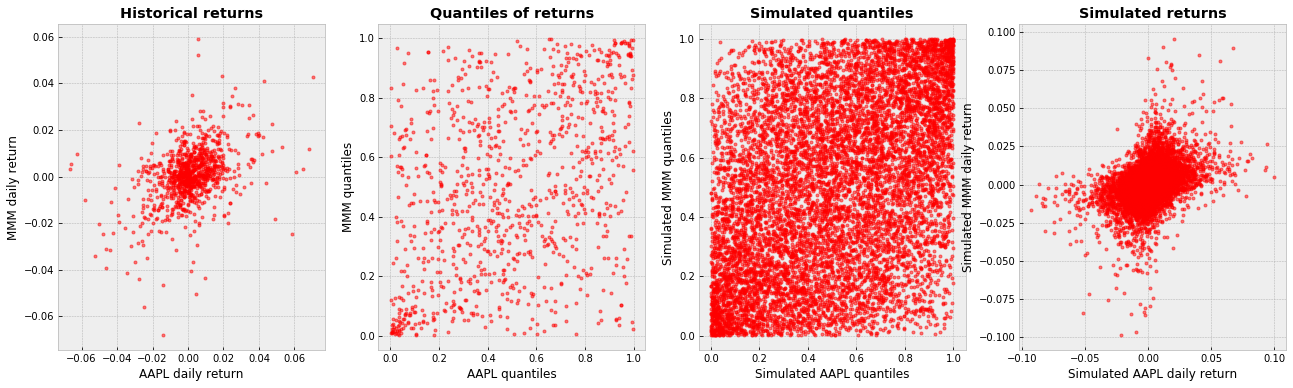

In [27]:
fig = plt.figure(figsize=(22, 6))

plt1 = fig.add_subplot(1,4,1)
plt2 = fig.add_subplot(1,4,2)
plt3 = fig.add_subplot(1,4,3)
plt4 = fig.add_subplot(1,4,4)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} quantiles".format(ticker_one))
plt2.set_ylabel("{} quantiles".format(ticker_two))
plt2.set_title("Quantiles of returns", weight="bold")


x = copula_simulations[ticker_one]
y = copula_simulations[ticker_two]
plt3.plot(x, y, "r.", alpha=0.5)

plt3.set_xlabel("Simulated {} quantiles".format(ticker_one))
plt3.set_ylabel("Simulated {} quantiles".format(ticker_two))
plt3.set_title("Simulated quantiles", weight="bold")


my_lim = 0.1
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt4.plot(x, y, "r.", alpha=0.5)

plt4.set_xlabel("Simulated {} daily return".format(ticker_one))
plt4.set_ylabel("Simulated {} daily return".format(ticker_two))
plt4.set_title("Simulated returns", weight="bold")

plt.show()

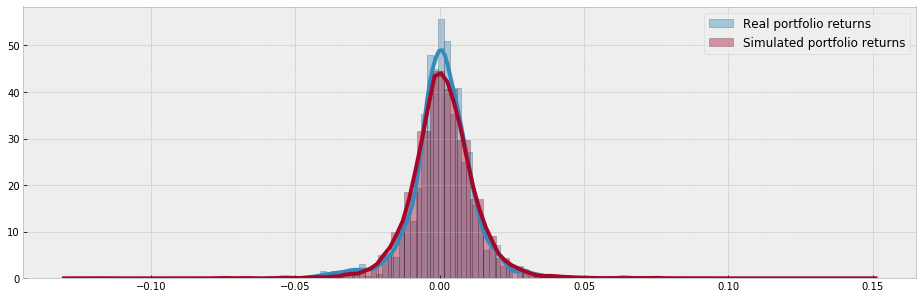

In [28]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [29]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.016684940782557837
-0.01616620618827364


#### Combining all steps together + trying different copulas and univariate distributions

In [30]:
from copulae import StudentCopula, ClaytonCopula, GumbelCopula

In [31]:
univariate_dist = 'gennorm' # gennorm
cop = StudentCopula(dim=cdfs.shape[1])
n_samples = 10 ** 4

cdfs = returns[selected_companies].copy()
distribution_params = {}

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = ss.t.fit(cdfs[col])
        distribution_params[col] = (t_df, t_mean, t_sigma)
        cdfs[col] = ss.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = ss.gennorm.fit(cdfs[col])
        distribution_params[col] = (beta, loc, scale)
        cdfs[col] = ss.gennorm.cdf(cdfs[col], beta, loc, scale)

cop.fit(cdfs)

copula_simulations = cop.random(n_samples, seed=42)
copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = distribution_params[col]
        return_simulations[col] = ss.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = distribution_params[col]
        return_simulations[col] = ss.gennorm.ppf(copula_simulations[col], beta, loc, scale)

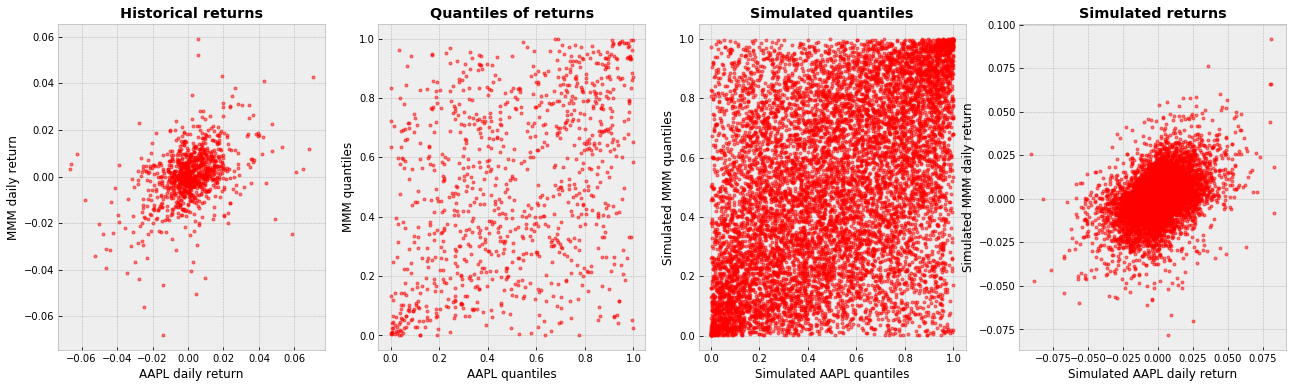

In [32]:
fig = plt.figure(figsize=(22, 6))

plt1 = fig.add_subplot(1,4,1)
plt2 = fig.add_subplot(1,4,2)
plt3 = fig.add_subplot(1,4,3)
plt4 = fig.add_subplot(1,4,4)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} quantiles".format(ticker_one))
plt2.set_ylabel("{} quantiles".format(ticker_two))
plt2.set_title("Quantiles of returns", weight="bold")


x = copula_simulations[ticker_one]
y = copula_simulations[ticker_two]
plt3.plot(x, y, "r.", alpha=0.5)

plt3.set_xlabel("Simulated {} quantiles".format(ticker_one))
plt3.set_ylabel("Simulated {} quantiles".format(ticker_two))
plt3.set_title("Simulated quantiles", weight="bold")


my_lim = 0.1
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt4.plot(x, y, "r.", alpha=0.5)

plt4.set_xlabel("Simulated {} daily return".format(ticker_one))
plt4.set_ylabel("Simulated {} daily return".format(ticker_two))
plt4.set_title("Simulated returns", weight="bold")

plt.show()

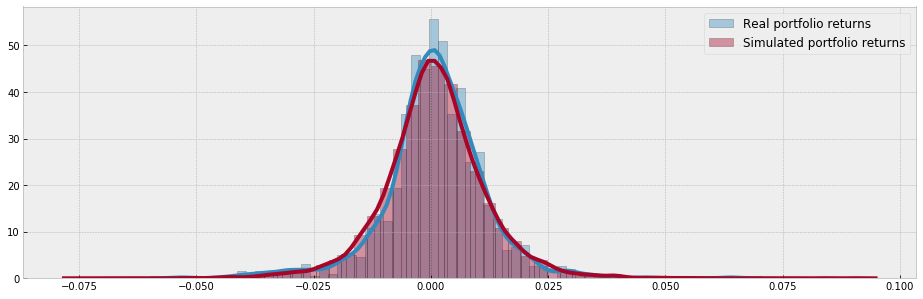

In [33]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [34]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.016684940782557837
-0.016284443836546265


#### Using GARCH as univariate distribution

In [35]:
from arch import arch_model 

def get_garch_residuals(ret, dist):

    scaling_const = 10.0 / ret.std()
    
    # объявляем GARCH модель
        
    am = arch_model(ret * scaling_const,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')

    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-2:])
        
    return cdf, am, res, scaling_const


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

In [36]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const = get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res, scaling_const)
            cdfs[col] = cdf

    # фитим копулу
    cop.fit(cdfs)
    

    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)
    

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res, scaling_const = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

In [37]:
return_simulations = make_copula_simulation(returns[selected_companies], NormalCopula,
                                            n_samples=10**4, univariate_dist='garch')

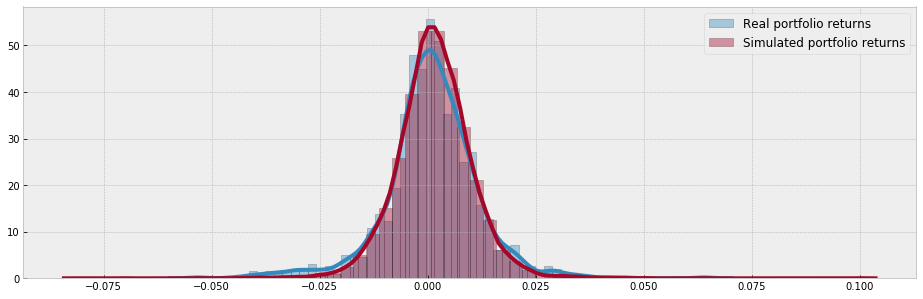

In [38]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

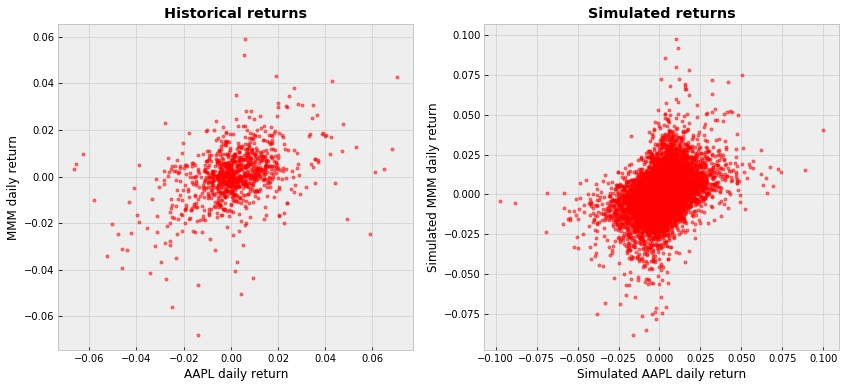

In [39]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")

my_lim = 0.1
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("Simulated {} daily return".format(ticker_one))
plt2.set_ylabel("Simulated {} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

In [40]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.016684940782557837
-0.012261419908679955


In [59]:
def make_copula_simulation_wrap(returns):
    return_simulations = make_copula_simulation(returns, NormalCopula,
                                            n_samples=10**3, univariate_dist='garch')
    
    return return_simulations

VaR_copulanorm_garch = calc_VaR(returns[selected_companies], make_copula_simulation_wrap, w_temp)

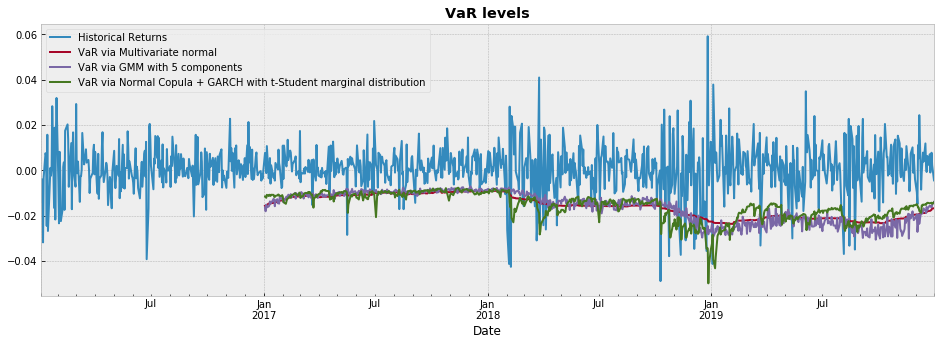

In [60]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
VaR_multy_normal.plot()
VaR_gmm_6.plot()
VaR_copulanorm_garch.plot()

plt.title("VaR levels", weight="bold")

plt.legend(['Daily returns and VaR curves',
            'VaR via Multivariate normal',
            'VaR via GMM with 5 components',
           'VaR via Normal Copula + GARCH with t-Student marginal distribution'])

plt.show()

## Backtesting VaR

In [61]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [62]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [63]:
def backtest_VaR(r, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [64]:
backtest_VaR(portfolio_real_returns_selected, VaR_HS, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_multy_normal, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_gmm_6, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_copulanorm_garch, 1-alpha)

Backtesting make_dummy_HS_simulations:
The proportion of hits is 6.24% instead of expected 5.0%
Two-sided p-val 0.131, one-sided: 0.073
green zone

Backtesting make_mult_normal_simulations:
The proportion of hits is 5.05% instead of expected 5.0%
Two-sided p-val 0.933, one-sided: 0.5
green zone

Backtesting make_gmm_simulations:
The proportion of hits is 6.37% instead of expected 5.0%
Two-sided p-val 0.0936, one-sided: 0.0537
green zone

Backtesting make_copula_simulation_wrap:
The proportion of hits is 5.44% instead of expected 5.0%
Two-sided p-val 0.558, one-sided: 0.31
green zone



## Homework

Download IBM, McDonalds and Microsoft stock price data for a period of '2017-07-01','2020-06-30' and calculate VaR curves for a portfolio (with weights $w_i=1/p_i$) using different approaches:

1. Use Historical simulation (modify the implementation from the univariate case)
2. Use GMM model. Select the optimal number of components using AIC or BIC criteria
3. Use Copula+GARCH model with constant mean, EGARCH(2, 1, 2) and skewed t-student distribution of residuals. Select the optimal copula type (fit different copula models and select the one with the highest Log Likelihood)
4. Optionally, use Copula+GARCH model and select the optimal copula type and GARCH parameters (fit different GARCH models and select the one with the highest Log Likelihood, then for standardized residuals fit different copula models and select the one with the highest Log Likelihood)


Then plot all VaR curves on one graph and conduct tests to select the most convenient approach. Finally, you should deliver:
1. One graph with daily historical returns and VaR curves
2. p-value for each model you use
3. Conclusion about what approach is the most suitable for this stock